# Car Price Prediction Model(Group 15)

## Data Preprocessing

In [830]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, MinMaxScaler
from sklearn.svm import OneClassSVM, SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import operator
import re
from sklearn.model_selection import GridSearchCV
def extract_hp(s):
    match = re.search(r'(\d+(\.\d+)?)HP', s)
    return float(match.group(1)) if match else float("0")

def extract_hp_with_avg(s):
    match = re.search(r'(\d+(\.\d+)?)HP', s)
    return float(match.group(1)) if match else average_hp

def extract_milage(s):
    numeric_string = ''.join(re.findall(r'\d+', s))
    if numeric_string:
        return int(numeric_string)
    else:
        return float("0")

def extract_monetary_value(s):
    # This pattern ignores non-numeric characters like $ and ,
    numeric_string = ''.join(re.findall(r'\d+', s))
    return int(numeric_string) if numeric_string else float("0")

def extract_model_year(s):
    try:
        year = int(s)
    except ValueError:
        # If "Nan"
        year = 2024
    # Compute and return the result.
    return 2024 - year

In [831]:
#load in data
dataset = pd.read_csv("./used_cars.csv")
#pre-process dataset to only the most popular 15 types of car will be used 
brand_counts = len(pd.unique(dataset['brand']))

# Choose the TOP15 brands from the dataset
top_15 = dataset['brand'].value_counts().head(15).index
dataset_top_brands = dataset[dataset['brand'].isin(top_15)]
dataset_top_brands.reset_index(drop=True, inplace=True)

dataset_top_brands = dataset

In [832]:
#use model_year, milage, price, horse_power for our models
# get rid of the mi. at the end to make milage numeric
dataset_top_brands['milage'] = dataset_top_brands['milage'].astype(str).apply(extract_milage)
#figure out the model-age 
dataset_top_brands['model_year'] = dataset_top_brands['model_year'].astype(str).apply(extract_model_year)
# get price 
dataset_top_brands['price'] = dataset_top_brands['price'].astype(str).apply(extract_monetary_value)
# get HP and set the hp to the average hp if not found
dataset_top_brands['horse_power'] = dataset_top_brands['engine'].apply(extract_hp).astype('float64')
average_hp = dataset_top_brands.loc[dataset_top_brands['horse_power'] > 0, 'horse_power'].median() # 310hp as average
dataset_top_brands['horse_power'] = dataset_top_brands['engine'].apply(extract_hp_with_avg).astype('float64')
dataset_top_brands['horse_power'] = dataset_top_brands['horse_power'].round(2)

In [833]:
dataset_top_brands.reset_index(drop=True, inplace=True)
dataset_top_brands = dataset_top_brands.drop(['brand', 'clean_title','fuel_type','transmission','engine','ext_col','int_col', 'model', 'accident'], axis=1)

dataset_top_brands

,model_year,milage,price,horse_power
0,11,51000,10300,300.0
1,3,34742,38005,310.0
2,2,22372,54598,310.0
3,9,88900,15500,354.0
4,3,9835,34999,310.0
...,...,...,...,...
4004,1,714,349950,310.0
4005,2,10900,53900,349.0
4006,2,2116,90998,310.0
4007,4,33000,62999,450.0


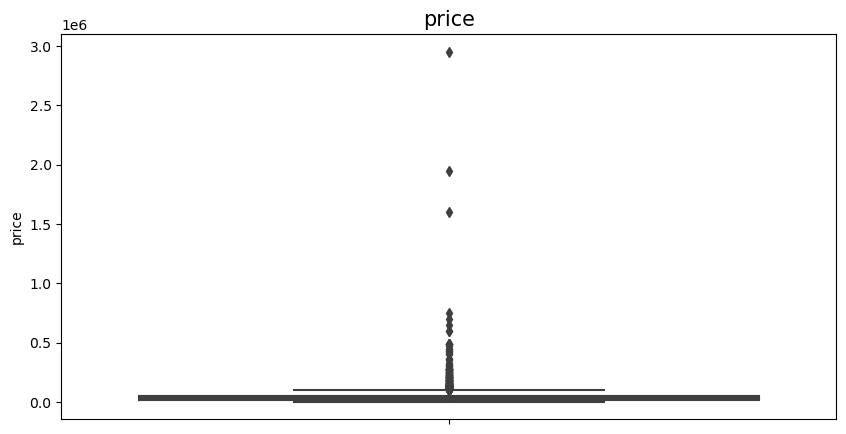

In [834]:
price = dataset_top_brands["price"]
fig = plt.figure(figsize=(10,5))

sns.boxplot(y = price)
plt.title('price', fontsize=15)
plt.show()

# Observation from the Boxplot
## We can see that for the numeric data in the boxplot, over 95% of the datapoints are within the price range of 90000. We can safely remove them from the dataset.

Number of datapoints left after dropping: 3704


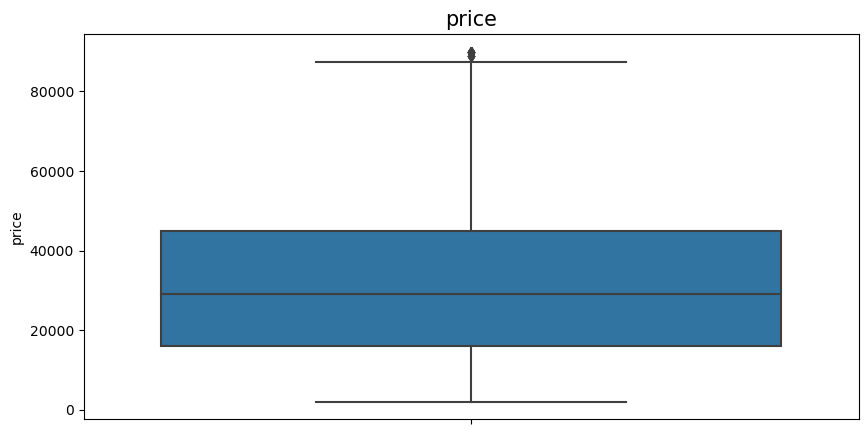

In [835]:
dataset_top_brands = dataset_top_brands[dataset_top_brands["price"] <= 90000]
print("Number of datapoints left after dropping:", len(dataset_top_brands))
price = dataset_top_brands["price"]
fig = plt.figure(figsize=(10,5))

sns.boxplot(y = price)
plt.title('price', fontsize=15)
plt.show()

<Axes: >

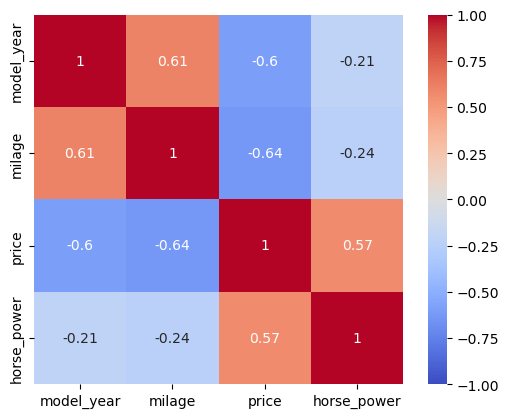

In [836]:
sns.heatmap(dataset_top_brands.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',square=True)

# Observation from the Heatmap
## We can see that for the numeric data in the heatmap, we can perceive the max correlation between price and milage(-0.64). We can then use milage as the X-value to further get rid of the outliers.

<class 'numpy.ndarray'>


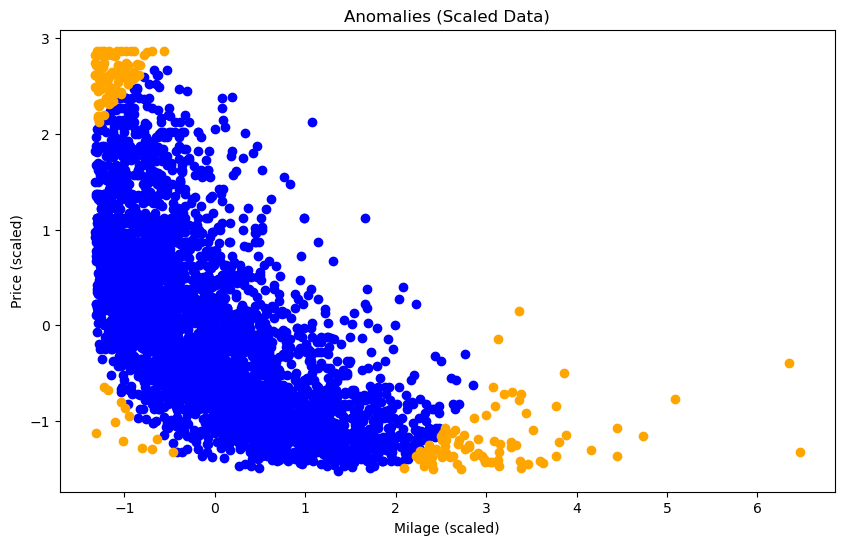

In [837]:
Data = dataset_top_brands[["milage","price"]]

input = Data.to_numpy()
print(type(input))

# Scale your features
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input)

# Try a range of gamma values
gamma_values = [0.001, 0.01, 0.1, 1]
nu_values = [0.01, 0.05, 0.1, 0.2]

best_gamma = None
best_nu = None
best_outlier_fraction = float('inf')  # Just a starting point, can be set to any large value

for gamma in gamma_values:
    for nu in nu_values:
        svm = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
        svm.fit(input_scaled)
        pred = svm.predict(input_scaled)
        outlier_fraction = sum(pred == -1) / len(pred)
        
        # Assuming we want the outlier fraction to be close to a certain value,
        # adjust the following condition accordingly:
        if abs(0.05 - outlier_fraction) < abs(0.05 - best_outlier_fraction):
            best_gamma = gamma
            best_nu = nu
            best_outlier_fraction = outlier_fraction

# After finding the best gamma and nu, visualize with these parameters
svm = OneClassSVM(kernel='rbf', gamma=best_gamma, nu=best_nu)
svm.fit(input_scaled)
pred = svm.predict(input_scaled)

inliers = input_scaled[pred == 1]
outliers = input_scaled[pred == -1]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Anomalies (Scaled Data)')
ax.scatter(inliers[:, 0], inliers[:, 1], color='blue')
ax.scatter(outliers[:, 0], outliers[:, 1], color='orange')
plt.xlabel('Milage (scaled)')
plt.ylabel('Price (scaled)')
plt.show()

In [838]:
inliers_mask = pred == 1

# The mask is currently for the scaled input, we need to apply this mask to the original dataframe
# Since the order of the rows hasn't changed, we can directly apply this mask to the dataframe
dataset_top_brands_inliers = dataset_top_brands[inliers_mask]
print("Dataset length after outlier operation: ",len(dataset_top_brands_inliers), "Datapoints")

Dataset length after outlier operation:  3518 Datapoints


# After preprocessing and outlier identifications, we can now safely build and train different models to see which model gives the best performance.

In [839]:
#scale the dataset
y = dataset_top_brands['price']

X = dataset_top_brands.drop(['price'], axis = 1)
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [840]:
def Print_Model_Stats(rmse, r2, mae):
    print('Training set metrics')
    print('-'*25)
    print(f'RMSE: {rmse.round(5)}')
    print(f'R-squared: {r2.round(5)}')
    print('MAE: ' + str(mae.round(5)))
    print('-'*25)

# Apply SVM Regression Model

In [841]:
def SVM_training_metrics(X_train, y_train):
    svm = SVR(kernel='rbf', C=100)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train.ravel(), y_pred))
    r2 = r2_score(y_train.ravel(), y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    
    Print_Model_Stats(rmse, r2, mae)
    return svm

In [842]:
svm_model = SVM_training_metrics(X_train, y_train)
# datapoint = model_year, milage_ HP, real price = 38000
Sample_Car_datapoint = [[3, 34372, 300]]

Training set metrics
-------------------------
RMSE: 13273.7704
R-squared: 0.56325
MAE: 8833.62085
-------------------------


# Apply Polynomial Regression Model(Degree 3)

In [974]:
def Poly_training_metrics(X_train, y_train, deg):
    polynomial_features = PolynomialFeatures(degree = deg, include_bias=False)
    x_poly_train = polynomial_features.fit_transform(X_train) 
    model = LinearRegression()
    model.fit(x_poly_train, y_train)
    y_train_pred = model.predict(x_poly_train)
    mae = mean_absolute_error(y_train, y_train_pred)
    rmse = np.sqrt(mean_squared_error(y_train.ravel(), y_train_pred))
    r2 = r2_score(y_train, y_train_pred)

    Print_Model_Stats(rmse, r2, mae)
    return model, x_poly_train, polynomial_features

In [975]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
degree = 3
poly_model, X_poly, polynomial_features = Poly_training_metrics(X_train, y_train, degree)

Training set metrics
-------------------------
RMSE: 10782.80488
R-squared: 0.71179
MAE: 7619.81564
-------------------------


# Apply Decision Tree Model

In [933]:
def Decision_Tree_training_metrics(X_train, y_train):
    tree = DecisionTreeRegressor(max_depth = 6)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train.ravel(), y_pred))
    r2 = r2_score(y_train.ravel(), y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    
    Print_Model_Stats(rmse, r2, mae)
    return tree

In [934]:
tree_model = Decision_Tree_training_metrics(X_train, y_train)

Training set metrics
-------------------------
RMSE: 10353.46532
R-squared: 0.73429
MAE: 7357.20263
-------------------------


# Apply Random Forest Model

In [935]:
def RF_training_metrics(X_train, y_train):
    RF = RandomForestRegressor(max_depth = 5, n_jobs = -1)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train.ravel(), y_pred))
    r2 = r2_score(y_train.ravel(), y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    
    Print_Model_Stats(rmse, r2, mae)
    return RF 

In [936]:
RF_model = RF_training_metrics(X_train, y_train)

Training set metrics
-------------------------
RMSE: 10358.11363
R-squared: 0.73405
MAE: 7398.5935
-------------------------


# Conclusion: 
### we can see that the Random Forest model gives the closet price prediction in the training dataset compared to the other three models, where the polynomial regression model, the decision Tree model, and the SVM have lower $R^2$ and higher Mean Absolute Error(MAE) than Random Forest Model, accordingly.

# Complete View in Plot
## Lets advance it further: plot the entire dataset with these models:
### SVM, Polynomial, Decision Tree, and Random Forest

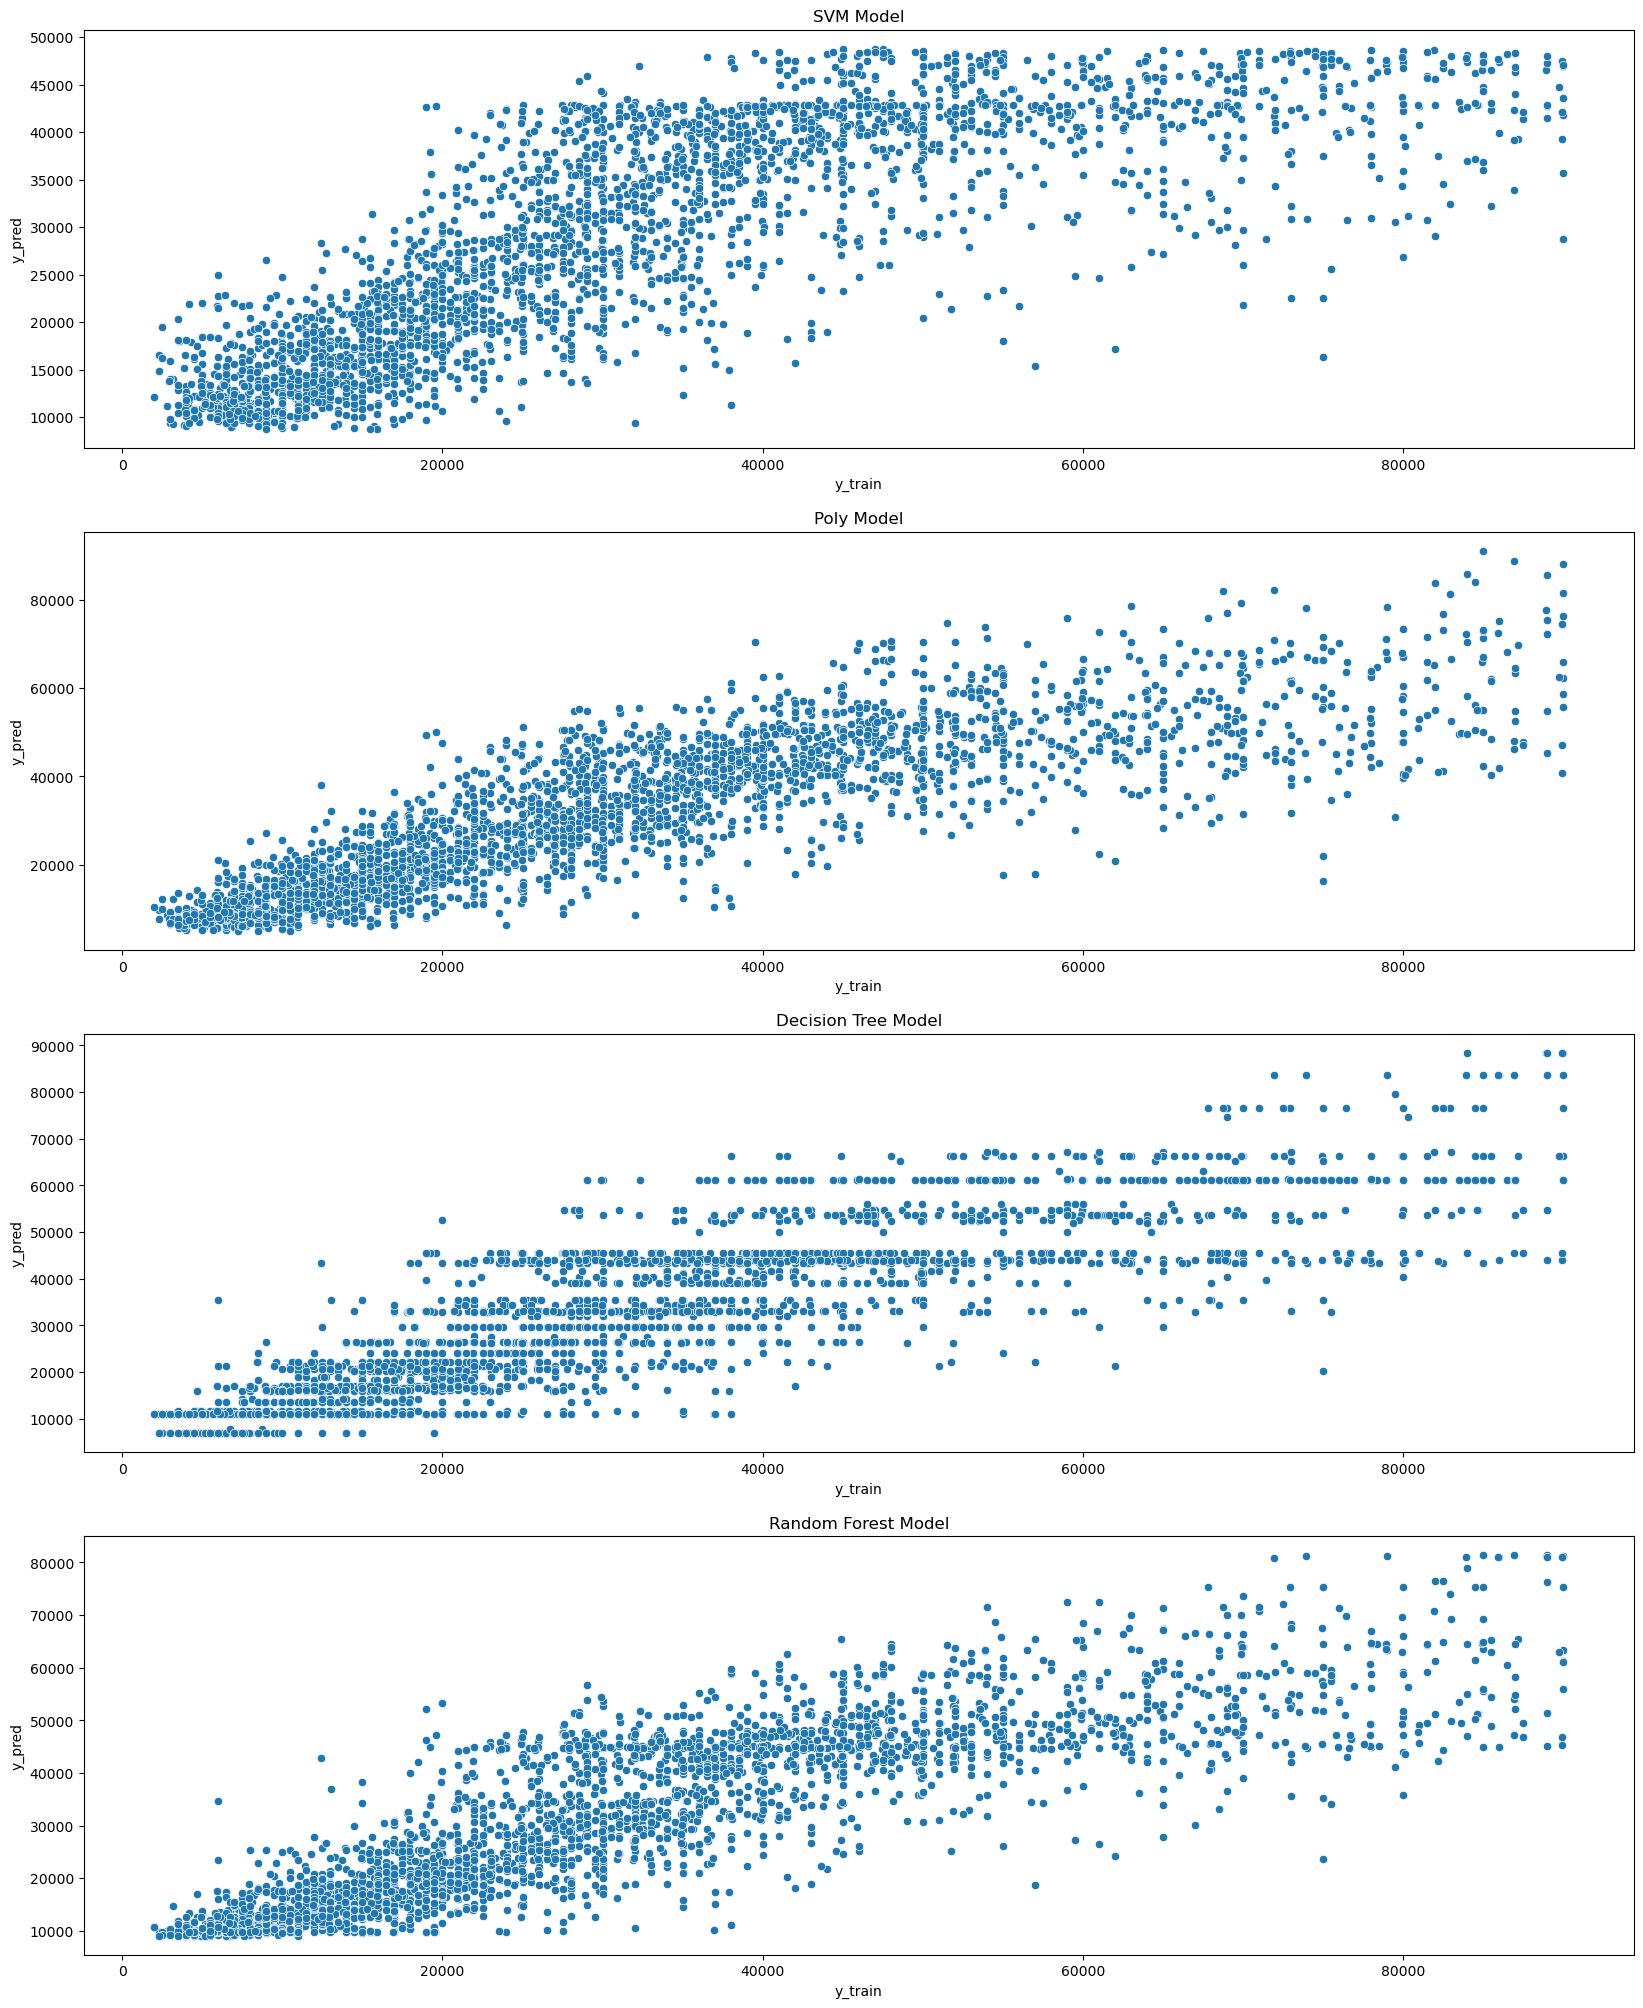

In [849]:
models = [svm_model, poly_model, tree_model, RF_model]    
model_names = ['SVM Model', 'Poly Model', 'Decision Tree Model', 'Random Forest Model']

fig, axes = plt.subplots(4,1, figsize = (20,25))

plt.subplots_adjust(hspace = 0.2)

for index, ax in enumerate(axes):      
    model = models[index]
    if index != 1:
        y_pred = model.predict(X_train)
    else:
        y_pred = model.predict(X_poly)
    
    sns.scatterplot(x = y_train.ravel(), y = y_pred.ravel(), ax = ax)
    ax.set_title(model_names[index])
    ax.set_xlabel('y_train')  # Set x-axis label
    ax.set_ylabel('y_pred')  # Set y-axis label
        
plt.show()

ys = pd.DataFrame(zip(y_train.values,y_pred), index = y_train.index.tolist(), columns = ['y_train', 'y_pred'])

### We can see that almost all models have underestimated the price value from the actual price. We improve more on the models that have the best performances: Decision Tree and RF models to perform grid search.

# Hyperparameter Tuning
## Grid Search on Decision Tree and RF

## Decision Tree Parameter Tuning

In [850]:
def Decision_Tree_training_metrics_after_tuning(X_train, y_train, tree_model):
    tree_model.fit(X_train, y_train)
    y_pred = tree.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train.ravel(), y_pred))
    r2 = r2_score(y_train.ravel(), y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    
    Print_Model_Stats(rmse, r2, mae)
    return tree

In [937]:
param_grid = {"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,10,11],
           "min_samples_leaf":[1,3,5,7,9,10,11],
           "max_features":[2,3,4,5]}

tree_reg = DecisionTreeRegressor()

grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose = 10, n_jobs = -1)

grid_search.fit(X_train, y_train.ravel())

print(grid_search.best_params_)
# # Run the data and got the parameters:
tree = DecisionTreeRegressor(max_depth = 7, max_features = 3, min_samples_leaf= 10, splitter = 'best')
print("\nTuned Decision Tree Model:")
Decision_Tree_training_metrics_after_tuning(X_train, y_train, tree)


Tuned Decision Tree Model:
Training set metrics
-------------------------
RMSE: 10086.77039
R-squared: 0.7478
MAE: 7158.89972
-------------------------


DecisionTreeRegressor(max_depth=7, max_features=3, min_samples_leaf=10)

### We notice an increase in all 3 indicators, meaning the parameter tuning has improved our Decision Tree model.

## Random Forest Parameter Tuning

In [938]:
def RF_training_metrics_after_tuning(X_train, y_train, RF):
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train.ravel(), y_pred))
    r2 = r2_score(y_train.ravel(), y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    
    Print_Model_Stats(rmse, r2, mae)
    return RF 

In [980]:
param_grid = {'n_estimators': [100,200,500], 'max_features': [2,3,5,8], "max_depth" : [3,5,10,12]}

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose = 10, n_jobs = -1)

grid_search.fit(X_train, y_train.ravel())

print(grid_search.best_params_)
# Run the data and got the parameters:
tuned_RF = RandomForestRegressor(max_depth = 10, max_features = 2, n_estimators = 200)
RF_training_metrics_after_tuning(X_train, y_train, tuned_RF)

Training set metrics
-------------------------
RMSE: 7417.16597
R-squared: 0.86363
MAE: 5167.42298
-------------------------


RandomForestRegressor(max_depth=10, max_features=2, n_estimators=200)

# Choosing the Best Model
## Finally, it is the time to decide on the best model with Test dataset:

In [872]:
def testdata_metrics(y_pred, y_test):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    index_test = y_test.index.tolist()
    
    df_ys = pd.DataFrame(zip(y_pred, y_test.values), index = index_test, columns = ['y_pred', 'y_test'])
    
    return r2, rmse, mae, df_ys

In [873]:
models = [poly_model, tree, tuned_RF]    
model_names = ['Polynomial Reg Model', 'Decision Tree', 'Random Forest']

result_df = pd.DataFrame(columns = ['Model', 'R2_Score', 'RMSE', 'MAE'])
y_dfs = []

for index, model in enumerate(models):
    
    name = model_names[index]
    if index == 0:
        y_pred_test = model.predict(polynomial_features.fit_transform(X_test))
    else:
        y_pred_test = model.predict(X_test)
        
    r2, rmse, mae, df_ys = testdata_metrics(y_pred_test, y_test)
    
    y_dfs.append(df_ys)
    
    result_df.loc[len(result_df)] = [name, r2, rmse, mae]

In [874]:
result_df

,Model,R2_Score,RMSE,MAE
0,Polynomial Reg Model,0.713356,10596.348068,7529.194286
1,Decision Tree,0.690306,11014.154877,7871.194742
2,Random Forest,0.721424,10446.151753,7339.186360


# Conclusion
### RF model gave a higher $R^2$ and lower RMSE and MAE in both the trianing dataset($R^2:0.86$) and testing  dataset($R^2:0.72$) outputs, following by the polynomial regression model and the Decision Tree model goes to the last. The ranking of these three models are(from best performance to least): 
# 1. Random Forest(the best model)
# 2. Polynomial Reg Model
# 3. Decision Tree	

# Some Sample datapoints plug into these 3 models:

In [922]:
def Sample_predict_price(datapoint, model, poly = False):
    if poly == False:
        prediction = model.predict(datapoint)
    else:
        prediction = model.predict(polynomial_features.fit_transform(datapoint))

    print("predicted price for this car is:" ,prediction[0].round(2))

# datapoint = [model_year, milage, HP]
# real price = [38000]

In [976]:
Sample_Car_datapoint = [[3, 34372, 310]]
Sample_predict_price(Sample_Car_datapoint, tree)

predicted price for this car is(real price 38000): 20663.18


In [981]:
Sample_Car_datapoint = [[3, 34372, 310]]
Sample_predict_price(Sample_Car_datapoint, tuned_RF)

predicted price for this car is(real price 38000): 39396.79


In [978]:
Sample_Car_datapoint = [[3, 34372, 310]]
Sample_predict_price(Sample_Car_datapoint, poly_model, True)
#what happened?

predicted price for this car is(real price 38000): -3.6869446579407913e+18
